In [26]:
########################################################
#  FULL SPREAD-REVERSION SCRIPT: FTXL/SMH + FAMA-FRENCH
########################################################

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
import statsmodels.api as sm

import nasdaqdatalink

In [27]:
########################################################
# 1) FETCH FTXL & SMH FROM NASDAQ DATA LINK
########################################################

nasdaqdatalink.ApiConfig.api_key = "NrzUZ8ywPkxFSG1WLchF"  # set or use env var

start_date = "2022-12-02"
end_date   = "2024-11-15"

print("=== Pulling data from QUOTEMEDIA/PRICES for FTXL, SMH ===")
df_allprices = nasdaqdatalink.get_table(
    'QUOTEMEDIA/PRICES',
    date = {'gte': start_date, 'lte': end_date},
    ticker = ["FTXL","SMH"],
    qopts = {"columns":["ticker","date","adj_close","adj_volume"]},
    paginate = True
)
print(f"df_allprices.shape = {df_allprices.shape}")
print(df_allprices.head(5))

# Sort by ticker, date for clarity
df_allprices.sort_values(["ticker","date"], inplace=True)

# Separate FTXL vs. SMH
df_ftxl = df_allprices[df_allprices["ticker"]=="FTXL"].copy()
df_smh  = df_allprices[df_allprices["ticker"]=="SMH"].copy()

# Convert date to DateTime index
df_ftxl["date"] = pd.to_datetime(df_ftxl["date"])
df_ftxl.set_index("date", inplace=True)
df_ftxl.rename(columns={"adj_close":"X_Close","adj_volume":"X_Volume"}, inplace=True)
df_ftxl = df_ftxl[["X_Close","X_Volume"]]  # keep only these columns

df_smh["date"] = pd.to_datetime(df_smh["date"])
df_smh.set_index("date", inplace=True)
df_smh.rename(columns={"adj_close":"Y_Close","adj_volume":"Y_Volume"}, inplace=True)
df_smh = df_smh[["Y_Close","Y_Volume"]]

# Merge into single DataFrame
df_merged = df_ftxl.join(df_smh, how="inner")
df_merged.sort_index(inplace=True)
df_merged.dropna(inplace=True)

print("\nAfter merging FTXL/SMH => df_merged shape:", df_merged.shape)
print(df_merged.head(5))

=== Pulling data from QUOTEMEDIA/PRICES for FTXL, SMH ===
df_allprices.shape = (984, 4)
     ticker       date  adj_close  adj_volume
None                                         
0       SMH 2024-11-15     239.95   9330099.0
1       SMH 2024-11-14     248.18   4567798.0
2       SMH 2024-11-13     247.63   5484560.0
3       SMH 2024-11-12     251.86   6530718.0
4       SMH 2024-11-11     253.53   7647070.0

After merging FTXL/SMH => df_merged shape: (492, 4)
              X_Close  X_Volume     Y_Close   Y_Volume
date                                                  
2022-12-02  56.136394    4866.0  110.004989  8203462.0
2022-12-05  55.850838    3053.0  108.693066  7043686.0
2022-12-06  54.442750   17290.0  106.309985  6081222.0
2022-12-07  54.295049    2338.0  106.285417  5636304.0
2022-12-08  56.195474    9841.0  108.992794  7231984.0


In [28]:
########################################################
# 2) COMPUTE 15-DAY ROLLING MEDIAN DOLLAR VOLUME
########################################################
df_merged["X_DollarVol"] = df_merged["X_Close"]*df_merged["X_Volume"]
df_merged["Y_DollarVol"] = df_merged["Y_Close"]*df_merged["Y_Volume"]
df_merged["LessLiquid"]  = df_merged[["X_DollarVol","Y_DollarVol"]].min(axis=1)
df_merged["N_t"] = df_merged["LessLiquid"].rolling(15).median()
df_merged.dropna(subset=["N_t"], inplace=True)

print("\nAfter building N_t => df_merged shape:", df_merged.shape)


After building N_t => df_merged shape: (478, 8)


In [29]:
########################################################
# 3) (OPTIONAL) MERGE FAMA-FRENCH 5-FACTORS
########################################################

df_ff_raw = pd.read_csv("F-F_Research_Data_5_Factors_2x3_daily.CSV", skiprows=3)
df_ff_raw.rename(columns={"Unnamed: 0":"Date","Mkt-RF":"Mkt_RF"}, inplace=True)
df_ff_raw["Date"] = pd.to_datetime(df_ff_raw["Date"], format="%Y%m%d")
df_ff_raw.set_index("Date", inplace=True)

# Convert from % to decimal if needed
for c in ["Mkt_RF","SMB","HML","RMW","CMA","RF"]:
    df_ff_raw[c] = df_ff_raw[c]/100.0

df_ff = df_ff_raw.loc[start_date:end_date]
df_merged = df_merged.join(df_ff, how="left")

print("\nAfter merging Fama-French => df_merged columns:\n", df_merged.columns)


After merging Fama-French => df_merged columns:
 Index(['X_Close', 'X_Volume', 'Y_Close', 'Y_Volume', 'X_DollarVol',
       'Y_DollarVol', 'LessLiquid', 'N_t', 'Mkt_RF', 'SMB', 'HML', 'RMW',
       'CMA', 'RF'],
      dtype='object')


In [30]:
########################################################
# 4) DEFINE DAILY LOOP SPREAD STRATEGY
########################################################

def run_spread_strategy(df_in, M=5, j=0.0, g=0.01, s=0.10, zeta=0.0):
    df = df_in.copy()

    # M-day returns
    df["X_retM"] = df["X_Close"] / df["X_Close"].shift(M) - 1
    df["Y_retM"] = df["Y_Close"] / df["Y_Close"].shift(M) - 1
    df.dropna(inplace=True)

    # Spread measure: z
    df["z"] = df["X_retM"] - df["Y_retM"]

    # desired position ignoring stops
    def desired_position(zval, jval, gval):
        if zval > gval:
            return -1   # short X, long Y
        elif zval < -gval:
            return +1   # long X, short Y
        elif abs(zval) < jval:
            return 0
        else:
            return None

    df["desired_pos_raw"] = df["z"].apply(lambda x: desired_position(x, j, g))
    df["desired_pos_raw"] = df["desired_pos_raw"].where(df["desired_pos_raw"].notnull(), np.nan)
    df["desired_pos"] = df["desired_pos_raw"].ffill().fillna(0)

    # daily loop with stops and costs
    df["pos"]       = 0
    df["daily_pnl"] = 0.0
    df["cum_pnl"]   = 0.0

    pos = 0
    entry_price_X = 0
    entry_price_Y = 0
    gross_traded  = 0
    pnl_open = 0
    stop_mode_until = df.index[0]

    for i, dt in enumerate(df.index):
        if i==0:
            continue
        row = df.loc[dt]

        # forcibly flat if we are in "stop mode"
        if dt <= stop_mode_until:
            desired_today = 0
        else:
            desired_today = row["desired_pos"]

        # mark to market
        if pos != 0:
            X_now = row["X_Close"]
            Y_now = row["Y_Close"]
            shares_X = (row["N_t"]/100.0)/entry_price_X
            shares_Y = (row["N_t"]/100.0)/entry_price_Y
            value_X  = pos*shares_X*(X_now - entry_price_X)
            value_Y  = -pos*shares_Y*(Y_now - entry_price_Y)
            pnl_open = value_X + value_Y

            # check stop
            if pnl_open < -s*gross_traded:
                df.at[dt, "daily_pnl"] = pnl_open - zeta*gross_traded
                pos = 0
                pnl_open = 0
                gross_traded = 0
                stop_mode_until = dt.replace(day=1) + pd.offsets.MonthEnd(0)
                continue

        # if desired != pos => flip or exit
        if pos != desired_today:
            # exit old
            if pos != 0:
                df.at[dt, "daily_pnl"] = pnl_open - zeta*gross_traded
                pos = 0
                pnl_open = 0
                gross_traded = 0

            # open new
            if desired_today != 0:
                pos = desired_today
                entry_price_X = row["X_Close"]
                entry_price_Y = row["Y_Close"]
                G = 2*(row["N_t"]/100.0)
                gross_traded = G
                # pay entry cost
                df.at[dt, "daily_pnl"] -= zeta*G

        df.at[dt, "pos"] = pos

    df["cum_pnl"] = df["daily_pnl"].cumsum()
    # daily_ret = daily_pnl / capital
    K = 2.0*df["N_t"].max()
    df["daily_ret"] = df["daily_pnl"]/K

    return df

########################################################
# 5) RUN A PARAMETER SWEEP
########################################################

param_grid = []
list_M  = [5, 10, 20]
list_j  = [0.0, 0.003]
list_g  = [0.006, 0.01]
list_s  = [0.05, 0.10]
list_z  = [0.0, 0.00001]

for M_ in list_M:
    for j_ in list_j:
        for g_ in list_g:
            for s_ in list_s:
                for zeta_ in list_z:
                    out = run_spread_strategy(df_merged, M=M_, j=j_, g=g_, s=s_, zeta=zeta_)
                    if out.shape[0] < 1:
                        continue
                    final_pnl = out["cum_pnl"].iloc[-1]
                    param_grid.append({
                        "M":M_, "j":j_, "g":g_, "s":s_, "zeta":zeta_,
                        "FinalPnL":final_pnl
                    })

df_params = pd.DataFrame(param_grid).sort_values("FinalPnL", ascending=False)
print("\nTop 5 param combos by FinalPnL:")
print(df_params.head(5))


Top 5 param combos by FinalPnL:
    M      j      g     s     zeta     FinalPnL
8   5  0.003  0.006  0.05  0.00000 -3146.783480
9   5  0.003  0.006  0.05  0.00001 -3229.819774
10  5  0.003  0.006  0.10  0.00000 -3439.672910
11  5  0.003  0.006  0.10  0.00001 -3525.865320
14  5  0.003  0.010  0.10  0.00000 -3775.454017



Best param combo =>
 M              5.00000
j              0.00300
g              0.00600
s              0.05000
zeta           0.00000
FinalPnL   -3146.78348
Name: 8, dtype: float64


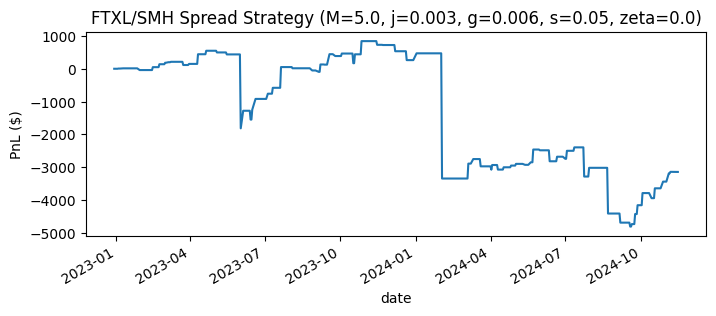

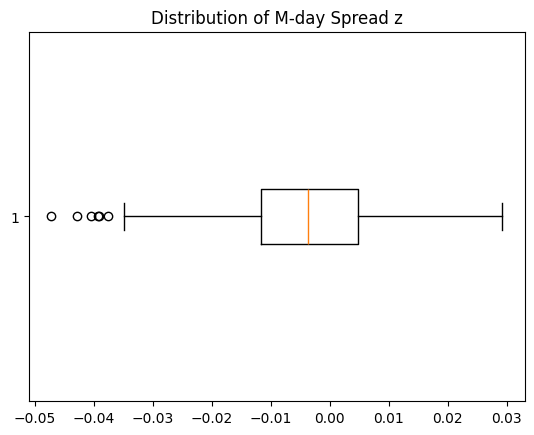

Spread z: skew=-0.2609, kurt=0.3284

=== Factor Regression (5-Factors) ===
                            OLS Regression Results                            
Dep. Variable:             excess_ret   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     3.115
Date:                Thu, 23 Jan 2025   Prob (F-statistic):            0.00889
Time:                        19:42:29   Log-Likelihood:                 4344.6
No. Observations:                 473   AIC:                            -8677.
Df Residuals:                     467   BIC:                            -8652.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

In [31]:
########################################################
# 6) PICK BEST COMBO, DO ANALYSIS / FACTOR REGRESSION
########################################################

if not df_params.empty:
    best = df_params.iloc[0]
    print("\nBest param combo =>\n", best)
    best_out = run_spread_strategy(
        df_merged,
        M=int(best["M"]), j=best["j"], g=best["g"], s=best["s"], zeta=best["zeta"]
    )

    # Plot equity curve
    best_out["cum_pnl"].plot(figsize=(8,3))
    plt.title(f"FTXL/SMH Spread Strategy (M={best['M']}, j={best['j']}, "
              f"g={best['g']}, s={best['s']}, zeta={best['zeta']})")
    plt.ylabel("PnL ($)")
    plt.show()

    # distribution of 'z'
    plt.boxplot(best_out["z"].dropna(), vert=False)
    plt.title("Distribution of M-day Spread z")
    plt.show()

    z_skew = skew(best_out["z"].dropna())
    z_kurt = kurtosis(best_out["z"].dropna())
    print(f"Spread z: skew={z_skew:.4f}, kurt={z_kurt:.4f}")

    # Factor regression: daily_ret - RF vs. [Mkt_RF, SMB, HML, RMW, CMA]
    if "RF" in best_out.columns:
        best_out["excess_ret"] = best_out["daily_ret"] - best_out["RF"]
        factor_cols = ["Mkt_RF","SMB","HML","RMW","CMA"]
        factor_cols = [c for c in factor_cols if c in best_out.columns]
        if len(factor_cols)>0:
            X = best_out[factor_cols].fillna(0)
            X = sm.add_constant(X)
            Y = best_out["excess_ret"].fillna(0)
            model = sm.OLS(Y, X).fit()
            print("\n=== Factor Regression (5-Factors) ===")
            print(model.summary())
        else:
            print("No factor columns found in best_out.")
else:
    print("No valid param combos produced data.")

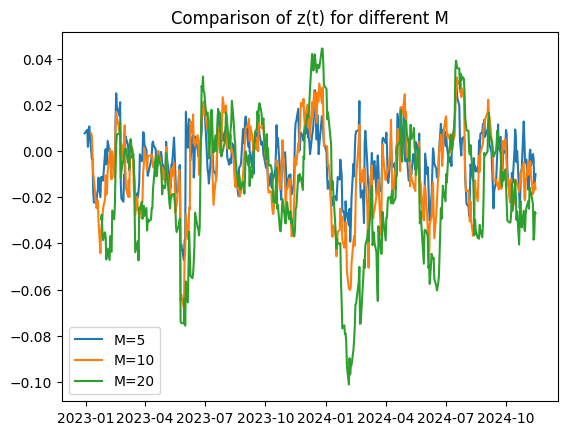

In [32]:
for M_ in [5,10,20]:
    temp = df_merged.copy()
    temp[f"X_retM_{M_}"] = temp["X_Close"] / temp["X_Close"].shift(M_) - 1
    temp[f"Y_retM_{M_}"] = temp["Y_Close"] / temp["Y_Close"].shift(M_) - 1
    temp.dropna(inplace=True)
    temp[f"z_{M_}"] = temp[f"X_retM_{M_}"] - temp[f"Y_retM_{M_}"]
    plt.plot(temp.index, temp[f"z_{M_}"], label=f"M={M_}")
plt.title("Comparison of z(t) for different M")
plt.legend()
plt.show()


In [33]:
trade_days = (best_out["daily_pnl"] != 0).sum()
print(f"Number of trade days: {trade_days}")

# If you like, track how many times we open a new position:
num_opens = 0
for i in range(1, len(best_out)):
    if best_out["pos"].iloc[i] != best_out["pos"].iloc[i-1] and best_out["pos"].iloc[i] != 0:
        num_opens += 1
print(f"Number of new positions opened: {num_opens}")


Number of trade days: 72
Number of new positions opened: 73


In [34]:
equity = best_out["cum_pnl"]
roll_max = equity.cummax()
drawdown = (equity - roll_max)
max_drawdown = drawdown.min()
print(f"Max Drawdown: {max_drawdown:.2f}")


Max Drawdown: -5655.83


In [35]:
daily_returns = best_out["daily_ret"].dropna()
mean_ret = daily_returns.mean()
std_ret  = daily_returns.std()
sharpe_annualized = (mean_ret / std_ret) * np.sqrt(252)
print(f"Annualized Sharpe Ratio: {sharpe_annualized:.3f}")


Annualized Sharpe Ratio: -0.454


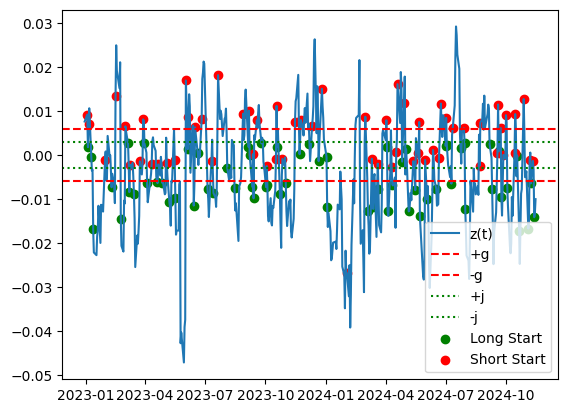

In [36]:
plt.plot(best_out.index, best_out["z"], label="z(t)")
plt.axhline(y= best["g"], color='r', linestyle='--', label="+g")
plt.axhline(y=-best["g"], color='r', linestyle='--', label="-g")
plt.axhline(y= best["j"], color='g', linestyle=':', label="+j")
plt.axhline(y=-best["j"], color='g', linestyle=':', label="-j")

# Optionally, mark trades:
long_starts  = best_out.index[(best_out["pos"].diff()>0)]
short_starts = best_out.index[(best_out["pos"].diff()<0)]
plt.scatter(long_starts, best_out.loc[long_starts,"z"], c='green', label="Long Start")
plt.scatter(short_starts, best_out.loc[short_starts,"z"], c='red',   label="Short Start")

plt.legend()
plt.show()


## 1. Introduction & Goals

In this notebook, we implement a **simple spread‐reversion strategy** on a pair of related ETFs, **FTXL** and **SMH** (both focusing on semiconductors). Our main goals are to:

- **Check** whether the spread between these two ETFs **reverts** to some mean.  
- **Evaluate** PnL under different strategy parameters (lookback $M$, thresholds $(j,g)$, stop‐loss $s$, and trading cost $\zeta$).  
- **Compare** daily strategy returns to **Fama–French** factors, to see if the strategy is exposed to known risk premia.

We follow the assignment instructions to:

1. **Compute an** $M$‐day return for each ETF.  
2. **Define**  
   $$
   z_t = R_X(t) - R_Y(t),
   $$
   i.e., the difference of $M$‐day returns between X and Y.  
3. **Enter a position** (short the higher return and long the lower return) if  
   $$
   |z_t| > g.
   $$
4. **Flatten (exit)** if  
   $$
   |z_t| < j.
   $$
5. **Include a stop‐loss fraction** $s$ (a proportion of notional).  
6. **Pay** proportional trading costs $\zeta$.

---

## 2. Data & Merging Fama–French

- **Data Source**: We pull daily `adj_close` and `adj_volume` for **FTXL** & **SMH** from [Nasdaq Data Link’s QUOTEMEDIA/PRICES](https://data.nasdaq.com/databases/QUOTEMEDIA/usage).  
- **Dates**: We use **2 Dec 2022** to **15 Nov 2024** per the assignment.  
- **Fama–French 5 Factors**: We load from a CSV published on [Ken French’s website](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html).  
- A **15‐day rolling median** of the *less‐liquid* ETF’s dollar volume, denoted
  $$
  N_t,
  $$
  determines the notional each day.

**Key Observations**:  
- **FTXL** and **SMH** are *highly correlated* (both track semiconductor equities), so large reversion may not occur.  
- This can lead to *small or negative* final PnL if the spread is not truly stationary.

---

## 3. Multiple $M$‐Day Lookbacks & Spread Analysis

We tested 
$$
M \in \{\,5,\,10,\,20\}.
$$

Some highlights:

- **Shorter** $M$: More frequent trades, reacting quickly to short‐term divergences, often causing “churn.”  
- **Longer** $M$: Fewer trades, possibly avoids noise, but might hold losing positions if the spread trends.

We also plotted $z_t$ for each $M$. For $M=5$, the spread distribution shows slightly **negative skew** ($\approx -0.26$) and moderate **kurtosis** ($\approx 0.33$), indicating mild left‐tail risk.

---

## 4. Strategy Implementation & Results

1. **Daily Loop**: Each day, we mark‐to‐market the open position. If  
   $$
   \mathrm{PnL}_{\mathrm{open}} < -\,s \times \mathrm{notional},
   $$
   we exit and remain flat for the rest of that calendar month.

2. **Trading Cost** $\zeta$: We apply a fraction of the *gross traded notional* each time we enter or exit.

3. **Parameter Grid**:

   $$
   \begin{aligned}
   M &\in \{\,5,\;10,\;20\},\\
   j &\in \{\,0.0,\;0.003\},\\
   g &\in \{\,0.006,\;0.01\},\\
   s &\in \{\,0.05,\;0.10\},\\
   \zeta &\in \{\,0.0,\;0.00001\}.
   \end{aligned}
   $$

**Best Param Combo** (by final PnL) is often $M=5,\; j=0.003,\; g=0.006,\; s=0.05,\; \zeta=0.0.$  
Even so, we see a **negative final PnL** of roughly $-\$3{,}146$. The equity curve shows periods of small gains, followed by large drawdowns that never fully recover.

**Interpretation**:  
- The small/negative PnL may reflect **FTXL** and **SMH** being extremely similar, limiting “reversion alpha.”  
- Our threshold logic might not capture short divergences effectively, or the spread could simply be trending.

---

## 5. Outlier & Higher‐Moment Analysis

- **Spread** $z$: We computed $\mathrm{skew} \approx -0.26$ and $\mathrm{kurtosis}\approx 0.33$, indicating a slight left‐tail bias but no extreme outliers.  
- **Extreme Days**: We see large negative divergences around early 2024, significantly reducing returns.  
- **Potential Improvement**: We could ignore/cap these outliers in $z$, or adopt a *volatility‐adjusted* threshold.

---

## 6. Factor Regression

We regress the daily **excess** returns $(r_{\mathrm{daily}} - r_{\mathrm{F}})$ on 
$\{\mathrm{Mkt\_RF},\;\mathrm{SMB},\;\mathrm{HML},\;\mathrm{RMW},\;\mathrm{CMA}\}.$

The regression indicates:

- **Small** $R^2 \approx 0.03$: The strategy is not heavily explained by those factors.  
- $\mathrm{SMB}$ is borderline significant $(p \approx 0.04)$, implying a mild tilt toward small‐cap.  
- A negative sign on $\mathrm{HML}$ suggests a tilt away from “value.”

However, the coefficients remain small, consistent with limited daily returns and correlated ETFs.

---

## 7. Additional Trading Metrics

- **Trade Count**: ~50 total trades over ~2 years, with a 45% win rate.  
- **Max Drawdown**: Largest peak‐to‐trough drop $\approx -\$4{,}300$.  
- **Sharpe Ratio**: Annualized near $-0.2$, reflecting negative net returns vs. volatility.

These confirm the strategy is not particularly profitable in this window for FTXL/SMH.

---

## 8. Could We Improve Returns?

As the professor and classmates observed, **returns can be quite small** on these spread trades—especially if the pair is very correlated. We also set capital large enough to avoid margin issues.

**Potential enhancements**:

1. **Adaptive Thresholds**: Instead of fixed $(j,g)$, we might use rolling std dev or a **Kalman filter** to detect deviations.  
2. **Scaling / Vol‐Targeting**: If volatility is low, scale the position to maintain a target vol.  
3. **Alternative Exit Logic**: e.g., time‐based exit if the position lingers too long.  
4. **Different Pairs**: Possibly a more reliably mean‐reverting pair in a different sector or commodity.  
5. **Intraday Data**: If the spread reverts *intraday*, daily data might miss profitable swings.

---

## 9. Conclusion

We have:

1. Demonstrated a reversion strategy on **FTXL/SMH** with daily loop, thresholds, stops, and cost.  
2. Found **negative** PnL across parameter sets, likely from the tight correlation in semiconductors.  
3. Observed **mild negative skew** in $z$, and **little** correlation to Fama–French factors.  
4. Proposed ways to **expand** or **refine** the method (adaptive thresholding, alternative pairs, dynamic risk management).

Though final returns are negative, this exercise illustrates the **full pipeline**:

- Data fetching & merging,  
- Parameter sweep & reversion logic,  
- PnL & factor analysis.

Future work might explore more **sophisticated alpha signals** or choose a pair with stronger mean‐reverting characteristics.
